In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set background and fontsize
rc_params = {
    'pdf.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'ps.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'axes.labelcolor': '#222222',
    'axes.labelsize': 9,
    'text.color': '#222222',
    'font.sans-serif' : 'Helvetica',
    'text.usetex': False,
    'figure.figsize': (7.2, 4.45),
    'xtick.major.size': 0.00,
    'ytick.major.size': 0.00,
    'axes.labelpad': 0.1,
    }
sns.set(style='white', context='paper', rc=rc_params,
        font_scale=1.0)

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

In [3]:
from replay_trajectory_classification.sorted_spikes_simulation import make_simulated_run_data

time, linear_distance, sampling_frequency, spikes, place_fields = make_simulated_run_data()

In [4]:
from dask.distributed import Client

Client(n_workers=2,
       threads_per_worker=2,
       processes=True,
       memory_limit='25GB')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59654,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:59662,Total threads: 2
Dashboard: http://127.0.0.1:59664/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:59658,


In [17]:
from replay_trajectory_classification.misc import TRANSITION_TO_CATEGORY, STATE_COLORS

def plot_classification(replay_time, test_spikes, results):
    fig, axes = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True, sharex=True)
    spike_time_ind, neuron_ind = np.nonzero(test_spikes)
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black', zorder=1,
                    marker='|', s=80, linewidth=3)
    axes[0].set_yticks((0, test_spikes.shape[1]))
    axes[0].set_ylabel('Neuron Index')
    replay_probability = results.acausal_posterior.sum('position')
    for state, prob in replay_probability.groupby('state'):
        axes[1].plot(prob.time, prob.values, linewidth=4, label=state, color=STATE_COLORS[state])
    axes[1].set_ylabel('Probability')
    axes[1].set_yticks([0, 1])
    axes[1].set_ylim((-0.01, 1.05))
    axes[1].legend(bbox_to_anchor=(1.15, 0.95), loc='upper right', fancybox=False, shadow=False,
                   ncol=1, frameon=False)
    
    results.acausal_posterior.sum('state').plot(
        x='time', y='position', robust=True, vmin=0.0, ax=axes[2])
    axes[2].set_ylabel('Position [cm]')
    plt.xlim((replay_time.min(), replay_time.max()))
    axes[-1].set_xlabel('Time [s]')
    sns.despine()

In [25]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_continuous_hover_replay


from replay_trajectory_classification import SortedSpikesClassifier, SortedSpikesDecoder
from replay_trajectory_classification.state_transition import estimate_movement_var
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform, Identity


movement_var = estimate_movement_var(linear_distance, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [[RandomWalk(movement_var=movement_var * 120),  Uniform(), Identity()],
                                [Uniform(),                                   Uniform(), Uniform()],
                                [RandomWalk(movement_var=movement_var * 120), Uniform(), Identity()],
                               ]

classifier = SortedSpikesClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    spike_model_penalty=0.5,
)

fit_args = dict(
    position=linear_distance,
    spikes=spikes
)

replay_time, test_spikes = make_hover_continuous_hover_replay()
state_names = ['continuous', 'fragmented', 'stationary']

predict_args = dict(
    spikes=test_spikes,
    time=replay_time,
    state_names=state_names,
)

results, data_log_likelihood = classifier.estimate_parameters(fit_args, predict_args)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Estimating likelihood...
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 0, likelihood: -37.790552447011265
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...
INFO:replay_trajectory_classification.classifier:iteration 1, likelihood: -35.966072644399844, change: 1.824479802611421
INFO:replay_trajectory_classification.classifier:Estimating causal posterior...
INFO:replay_trajectory_classification.classifier:Estimating acausal posterior...

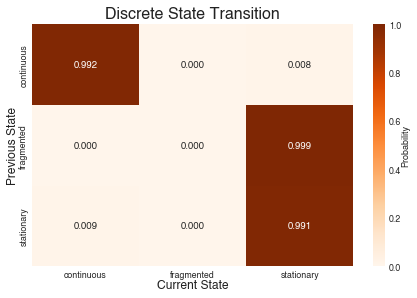

In [21]:
classifier.plot_discrete_state_transition(state_names=state_names)

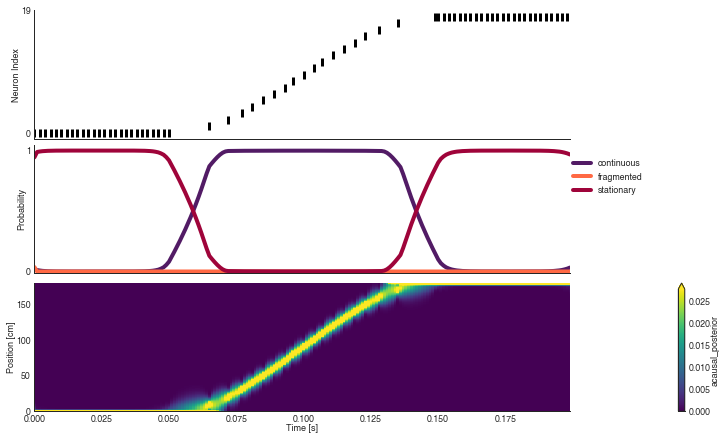

In [22]:
plot_classification(replay_time, test_spikes, results)